# Predicting Water Levels for the Auser Aquifer

## Importing libraries and dataset

In [40]:
import pandas as pd 
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
aus = pd.read_csv('Aquifer_Auser.csv')

## Performing the same initial transformations as the first notebook

In [3]:
aus['Date'] = pd.to_datetime(aus['Date'], format='%d/%m/%Y')

In [4]:
abs_cols = ['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC',
           'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL']
# absolute values can be taken from the above columns as clarified by competition host in a discussion thread on kaggle

In [5]:
for col in abs_cols:
    aus[col] = abs(aus[col])

## Further EDA, Cleaning and Feature Engineering

As observed in the first notebook: 

- Values for the features of Volume CSA & CSAL from before 2014 were all zeros. Since these features are independent variables to be used as predictors, only data from 2014 onwards will be used.

- Temperature Ponte a Moriano contains 0 values from 2017 onwards indicating that the field instrument failed and wasn't replaced/repaired. This feature will be dropped.

- Depth and Hydrometry measurements have some 0 values and null values. 0 values are taken to be instrument failures and are thus replaced with null and subsequently filled by interpolation.

In [6]:
aus = aus.loc[aus['Date'] >= '01/01/2014']
aus.drop('Temperature_Ponte_a_Moriano', axis=1, inplace=True)
aus.reset_index(inplace=True, drop=True)

In [7]:
null_0_cols = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
       'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC', 'Depth_to_Groundwater_LT2',
       'Hydrometry_Monte_S_Quirico',
       'Hydrometry_Piaggione']

In [8]:
for col in null_0_cols:
    aus[col] = aus[col].replace(0, np.nan)

In [9]:
for col in null_0_cols:
    aus[col] = aus[col].interpolate()

In [10]:
aus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     2373 non-null   datetime64[ns]
 1   Rainfall_Gallicano                       2373 non-null   float64       
 2   Rainfall_Pontetetto                      2373 non-null   float64       
 3   Rainfall_Monte_Serra                     2373 non-null   float64       
 4   Rainfall_Orentano                        2373 non-null   float64       
 5   Rainfall_Borgo_a_Mozzano                 2373 non-null   float64       
 6   Rainfall_Piaggione                       2373 non-null   float64       
 7   Rainfall_Calavorno                       2373 non-null   float64       
 8   Rainfall_Croce_Arcana                    2373 non-null   float64       
 9   Rainfall_Tereglio_Coreglia_Antelminelli  

In [11]:
aus.loc[aus['Depth_to_Groundwater_CoS'].isnull()].head()
# interpolate failed as missing values were present in dataset since before 1 Jan 2014.

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Orentano,Temperature_Monte_Serra,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
0,2014-01-01,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.55,4.15,4.55,8311.680,16453.1520,11924.0640,5087.258065,3680.838710,0.47,-0.50
1,2014-01-02,2.8,0.4,0.0,0.2,2.0,0.8,1.8,0.0,0.8,...,6.05,5.60,7.05,8311.680,16453.1520,11924.0640,5087.258065,3680.838710,0.48,-0.51
2,2014-01-03,36.6,33.2,44.2,45.4,78.2,40.6,35.2,1.4,0.2,...,10.50,7.95,10.35,8311.680,16453.1520,11924.0640,5087.258065,3680.838710,0.64,0.15
3,2014-01-04,12.2,15.4,25.6,11.0,23.6,10.2,14.2,0.0,1.2,...,12.45,8.75,12.65,8311.680,16453.1520,11924.0640,5087.258065,3680.838710,0.80,0.79
4,2014-01-05,132.0,30.2,27.2,25.0,138.0,39.8,66.0,18.0,0.8,...,8.90,6.30,10.00,7896.096,15630.4944,11327.8608,4832.895161,3496.796774,1.67,3.39


In [12]:
# checking the original dataset, the last value for 'Depth_to_Groundwater_CoS' was on 3 Dec 2013 with a value of 6.36
# the next non-null cell was found on 20 Mar 2014 with a value of 5.41
# based on interpolation the value on 1 Jan 2014 is
aus['Depth_to_Groundwater_CoS'][0] = 6.36-28*(6.36-5.41)/(28+31+28+19)

<ipython-input-12-60e98296d69f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aus['Depth_to_Groundwater_CoS'][0] = 6.36-28*(6.36-5.41)/(28+31+28+19)


In [13]:
aus['Depth_to_Groundwater_CoS'] = aus['Depth_to_Groundwater_CoS'].interpolate()

In [14]:
aus.set_index("Date", inplace=True)

In [15]:
aus.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2373 entries, 2014-01-01 to 2020-06-30
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Rainfall_Gallicano                       2373 non-null   float64
 1   Rainfall_Pontetetto                      2373 non-null   float64
 2   Rainfall_Monte_Serra                     2373 non-null   float64
 3   Rainfall_Orentano                        2373 non-null   float64
 4   Rainfall_Borgo_a_Mozzano                 2373 non-null   float64
 5   Rainfall_Piaggione                       2373 non-null   float64
 6   Rainfall_Calavorno                       2373 non-null   float64
 7   Rainfall_Croce_Arcana                    2373 non-null   float64
 8   Rainfall_Tereglio_Coreglia_Antelminelli  2373 non-null   float64
 9   Rainfall_Fabbriche_di_Vallico            2373 non-null   float64
 10  Depth_to_Groundwater_LT2      

### Rolling 7 and searching for the best shift

In [16]:
aus_lt2 = aus.copy()
aus_sal = aus.copy()
aus_cos = aus.copy()

#### Best shift for features with respect to LT2 Depth

In [17]:
rollers_lt2 = [col for col in aus.columns if "LT2" not in col]

In [18]:
for col in rollers_lt2:
    aus_lt2[col] = aus_lt2[col].rolling(7).mean()

In [20]:
# shifting from 7 to 90 days since the number of days after that rainfall and temperatures affect the depths are unknown. 
# 7 days is the minimum since the model is meant to serve as a week-ahead forecast.
# shift with highest correlation with the target variable is kept.
# Other features are also shifted by 7 to serve as input for the week-ahead forecast.

for col in rollers_lt2:
    
    if 'Rainfall' in col:
        corr = 0
        for i in range(7,90):
            temporary_corr = abs(aus_lt2[[col]].shift(i).corrwith(aus_lt2['Depth_to_Groundwater_LT2'])[0])
            if temporary_corr > corr:
                corr = temporary_corr
                aus_lt2[col+"_shift_selected"] = aus_lt2[col].shift(i)
            
    if 'Temperature' in col:
        corr = 0
        for i in range(7,90):
            temporary_corr = abs(aus_lt2[[col]].shift(i).corrwith(aus_lt2['Depth_to_Groundwater_LT2'])[0])
            if temporary_corr > corr:
                corr = temporary_corr
                aus_lt2[col+"_shift_selected"] = aus_lt2[col].shift(i)
    
    else:
        aus_lt2[col]=aus_lt2[col].shift(7)

In [23]:
aus_lt2.drop(['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra',
       'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione',
       'Rainfall_Calavorno', 'Rainfall_Croce_Arcana',
       'Rainfall_Tereglio_Coreglia_Antelminelli',
       'Rainfall_Fabbriche_di_Vallico',
       'Temperature_Orentano', 'Temperature_Monte_Serra',
       'Temperature_Lucca_Orto_Botanico'], axis = 1, inplace=True)

In [24]:
def heat(df, name):
    mask = np.triu(df.corr());
    plt.figure(figsize=(20,20));
    ax = plt.axes();
    ax.set_title("Heatmap of Corr for " + str(name));
    sns.heatmap(df.corr(), ax=ax, vmin=-1.0, vmax=1.0, cmap='coolwarm', annot=True, square=True, mask=mask, linewidths=.1, fmt=".2f");

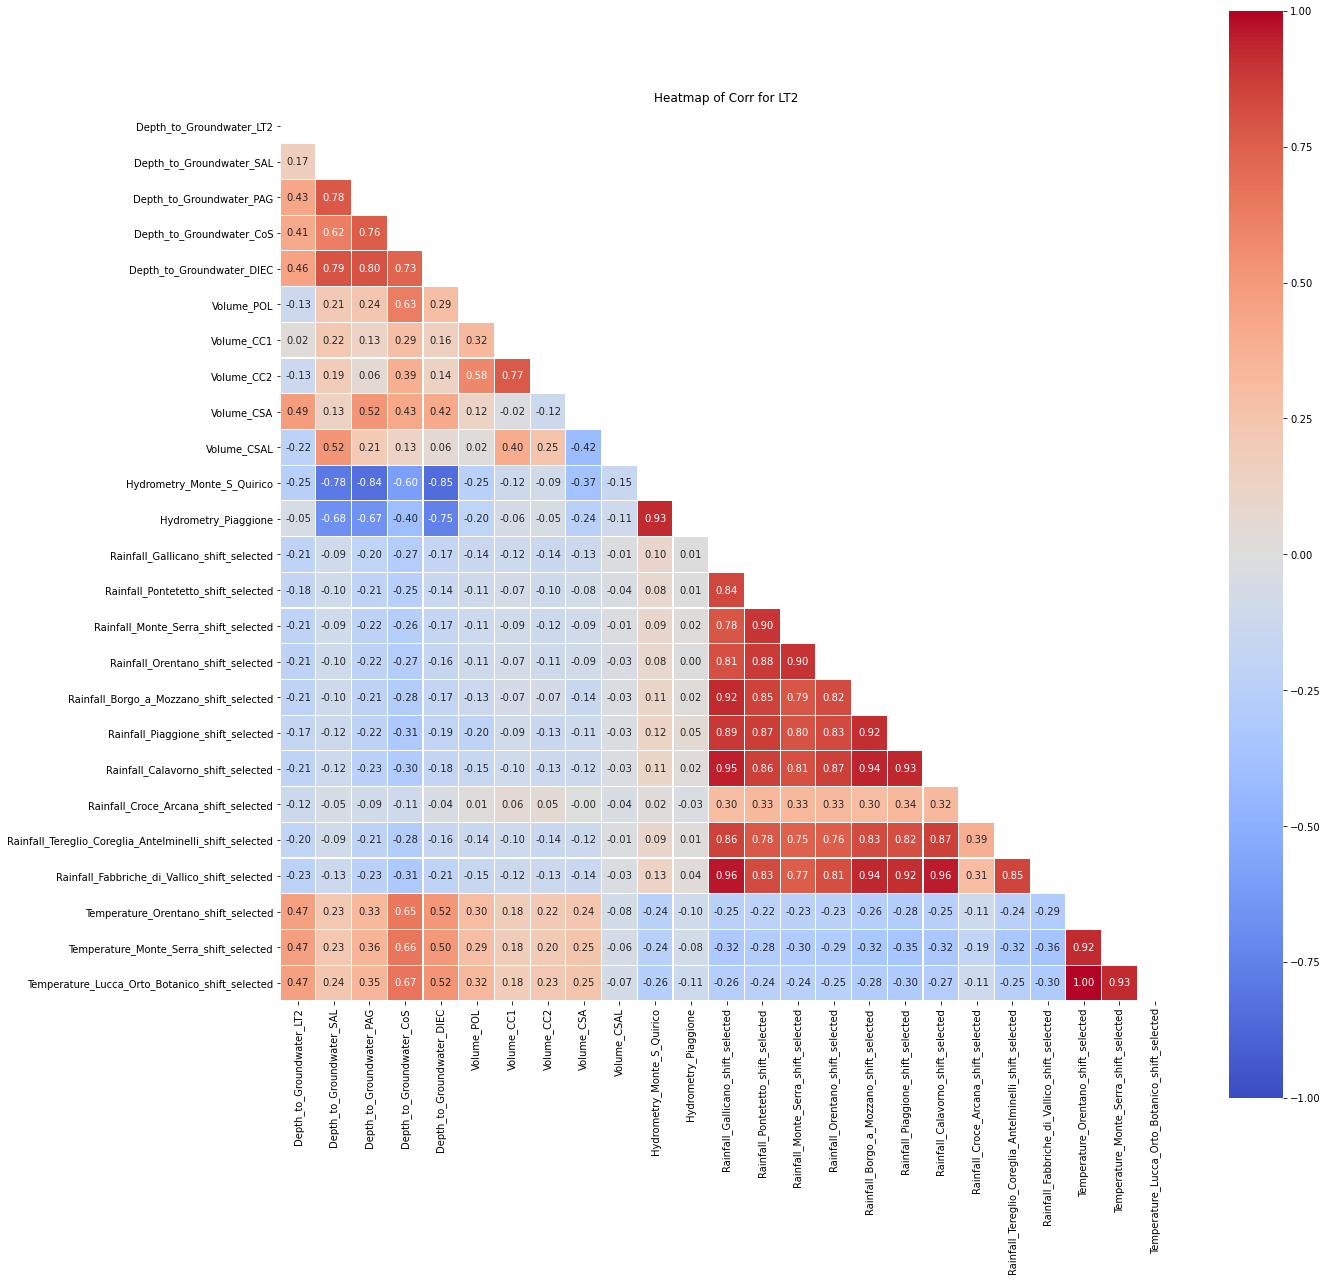

In [25]:
heat(aus_lt2, 'LT2')

#### Best shift for features with respect to SAL Depth

In [27]:
rollers_sal = [col for col in aus.columns if "Depth_to_Groundwater_SAL" not in col]

In [29]:
for col in rollers_sal:
    aus_sal[col] = aus_sal[col].rolling(7).mean()

In [30]:
for col in rollers_sal:
    
    if 'Rainfall' in col:
        corr = 0
        for i in range(7,90):
            temporary_corr = abs(aus_sal[[col]].shift(i).corrwith(aus_sal['Depth_to_Groundwater_SAL'])[0])
            if temporary_corr > corr:
                corr = temporary_corr
                aus_sal[col+"_shift_selected"] = aus_sal[col].shift(i)
            
    if 'Temperature' in col:
        corr = 0
        for i in range(7,90):
            temporary_corr = abs(aus_sal[[col]].shift(i).corrwith(aus_sal['Depth_to_Groundwater_SAL'])[0])
            if temporary_corr > corr:
                corr = temporary_corr
                aus_sal[col+"_shift_selected"] = aus_sal[col].shift(i)
    
    else:
        aus_sal[col]=aus_sal[col].shift(7)

In [31]:
aus_sal.drop(['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra',
       'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione',
       'Rainfall_Calavorno', 'Rainfall_Croce_Arcana',
       'Rainfall_Tereglio_Coreglia_Antelminelli',
       'Rainfall_Fabbriche_di_Vallico',
       'Temperature_Orentano', 'Temperature_Monte_Serra',
       'Temperature_Lucca_Orto_Botanico'], axis = 1, inplace=True)

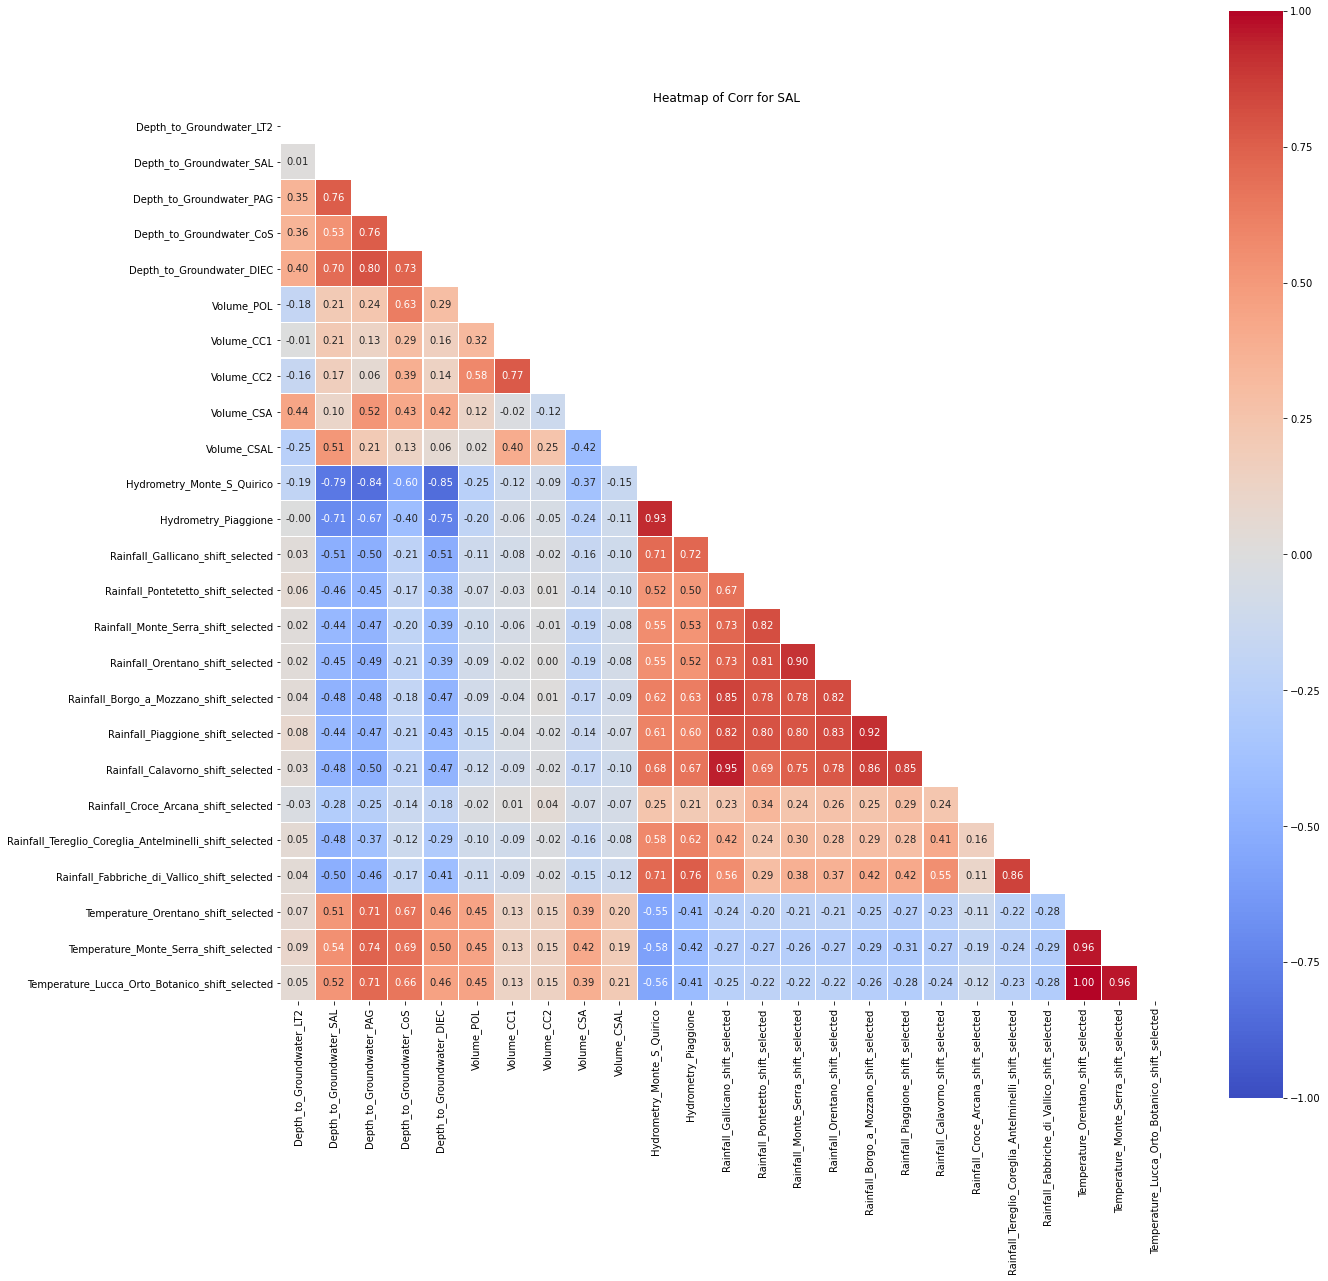

In [32]:
heat(aus_sal, 'SAL')

#### Best shift for features with respect to CoS Depth

In [33]:
rollers_cos = [col for col in aus.columns if "Depth_to_Groundwater_CoS" not in col]

In [35]:
for col in rollers_cos:
    aus_cos[col] = aus_cos[col].rolling(7).mean()

In [36]:
for col in rollers_cos:
    
    if 'Rainfall' in col:
        corr = 0
        for i in range(7,90):
            temporary_corr = abs(aus_cos[[col]].shift(i).corrwith(aus_cos['Depth_to_Groundwater_SAL'])[0])
            if temporary_corr > corr:
                corr = temporary_corr
                aus_cos[col+"_shift_selected"] = aus_cos[col].shift(i)
            
    if 'Temperature' in col:
        corr = 0
        for i in range(7,90):
            temporary_corr = abs(aus_cos[[col]].shift(i).corrwith(aus_cos['Depth_to_Groundwater_SAL'])[0])
            if temporary_corr > corr:
                corr = temporary_corr
                aus_cos[col+"_shift_selected"] = aus_cos[col].shift(i)
    
    else:
        aus_cos[col]=aus_cos[col].shift(7)

In [37]:
aus_cos.drop(['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra',
       'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione',
       'Rainfall_Calavorno', 'Rainfall_Croce_Arcana',
       'Rainfall_Tereglio_Coreglia_Antelminelli',
       'Rainfall_Fabbriche_di_Vallico',
       'Temperature_Orentano', 'Temperature_Monte_Serra',
       'Temperature_Lucca_Orto_Botanico'], axis = 1, inplace=True)

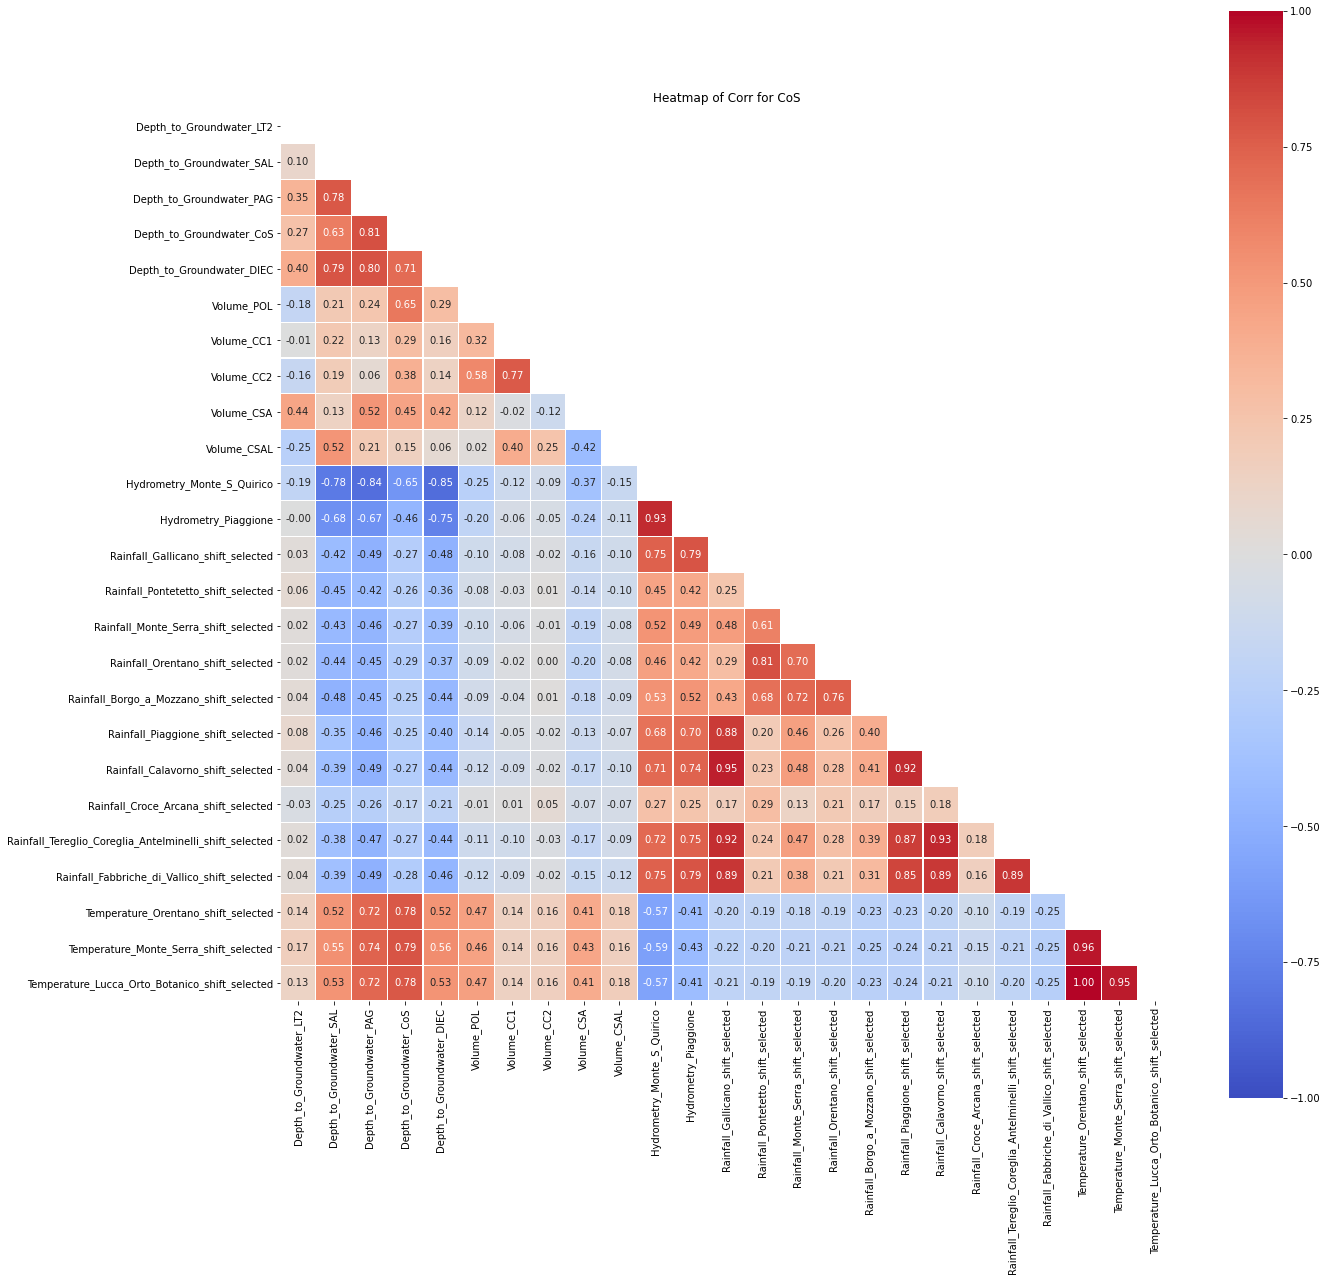

In [38]:
heat(aus_cos, 'CoS')

### Modeling

In [42]:
dfs = [aus_lt2, aus_sal, aus_cos]

In [49]:
for df in dfs:
    df.dropna(inplace=True)
    df['month'] = df.index.month
    df['year'] = df.index.year

#### LT2

In [51]:
X = aus_lt2.drop('Depth_to_Groundwater_LT2', axis=1)
y = aus_lt2['Depth_to_Groundwater_LT2']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [53]:
ss = StandardScaler()

In [54]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [55]:
sgd = SGDRegressor(random_state = 42)

In [56]:
sgd.fit(X_train_scaled, y_train)

SGDRegressor(random_state=42)

In [57]:
np.sqrt(mean_squared_error(y_train, sgd.predict(X_train_scaled)))

0.15712455370408307

In [58]:
np.sqrt(mean_squared_error(y_test, sgd.predict(X_test_scaled)))

0.16480839453084822

#### SAL

In [59]:
X = aus_sal.drop('Depth_to_Groundwater_SAL', axis=1)
y = aus_sal['Depth_to_Groundwater_SAL']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [61]:
ss = StandardScaler()

In [62]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [63]:
sgd = SGDRegressor(random_state = 42)

In [64]:
sgd.fit(X_train_scaled, y_train)

SGDRegressor(random_state=42)

In [65]:
np.sqrt(mean_squared_error(y_train, sgd.predict(X_train_scaled)))

0.1625162949085826

In [66]:
np.sqrt(mean_squared_error(y_test, sgd.predict(X_test_scaled)))

0.1537077199498274

#### CoS

In [67]:
X = aus_sal.drop('Depth_to_Groundwater_CoS', axis=1)
y = aus_sal['Depth_to_Groundwater_CoS']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [69]:
ss = StandardScaler()

In [70]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [71]:
sgd = SGDRegressor(random_state = 42)

In [72]:
sgd.fit(X_train_scaled, y_train)

SGDRegressor(random_state=42)

In [73]:
np.sqrt(mean_squared_error(y_train, sgd.predict(X_train_scaled)))

0.29392608831149997

In [74]:
np.sqrt(mean_squared_error(y_test, sgd.predict(X_test_scaled)))

0.3165450480276029